# Práctico

El trabajo práctico de la materia consiste en el análisis de un conjunto de datos extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

## Configuración inicial

In [ ]:
import seaborn as sns

In [ ]:
pip install igraph

     |████████████████████████████████| 3.2 MB 30.2 MB/s 


In [ ]:
import pandas as pd
from pathlib import Path
import networkx as nx
import igraph as ig

import matplotlib.pyplot as plt
import numpy as np
from time import time

## Creamos el directorio en caso de que no exista
DATA_DIR.mkdir(parents=True, exist_ok=True)

### Cargamos el dataset

In [ ]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}
df = pd.read_csv('vacunas.csv', dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [ ]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [ ]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [ ]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

## Actividades

### Primera parte

#### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.




In [ ]:
df

,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN
...,...,...,...,...,...,...,...,...
163174,Tue Jan 12 23:24:10 +0000 2021,1349135109010677767,@Die_IsCast @norabar @enzosebastin221 Retuitea...,1349122147587940353,2955376486,176835482,[],NaN
163175,Wed Jan 13 01:56:56 +0000 2021,1349173553833381888,"@todosflotan @norabar @enzosebastin221 Sí, sí,...",1349135109010677767,176835482,2955376486,[],NaN
163176,Wed Jan 13 02:02:07 +0000 2021,1349174860702953474,@Die_IsCast @norabar @enzosebastin221 seguí co...,1349173553833381888,2955376486,176835482,[],NaN
163177,Tue Jan 12 15:07:16 +0000 2021,1349010059712491522,"@mirtapsp @todosflotan @norabar Nora, trabaja ...",1349002034968719360,138734328,1219302815916527618,[],NaN


In [ ]:
G = nx.Graph()


Intentamos armarlo con DiGraph, pero en uno de los puntos posteriores la librería no funcionaba con gráficos dirigidos, por lo que optamos por la versión no dirigida

In [ ]:
edges = df.apply( lambda row : [( row['user.id'] , v ) for v in row['user_retweeters']] ,  axis=1 )


In [ ]:
for edge in edges:
    G.add_edges_from(edge)

In [ ]:
print(nx.info(G))


Graph with 39800 nodes and 93404 edges


## Grado medio

In [ ]:
deg_seq = np.array([k for v, k in G.degree()])

grado_medio = sum(deg_seq) / len(deg_seq)
grado_medio

4.693668341708543

Cada uno de los nodos está conectado con otros 5, en media.

## Asortatividad

In [ ]:
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

-0.22131902542941814

Por su valor, la probabilidad de que dos nodos con la misma propiedad estén conectados es muy baja.

## Transitividad 

In [ ]:
transitivity = nx.transitivity(G)
transitivity

0.0016125612488585316

Implica que hay muy pocas triadas conectadas, es decir que apunta en la misma direccion que la asortatividad.


## Coeficiente de clustering de Watts-Strogatz

In [ ]:
avg_clustering = nx.average_clustering(G)
avg_clustering

0.09990623904532091

Mide la posibilidad de que dos nodos conectados al mismo nodo también estén conectados entre si. En este caso es muy baja.

### **5. Embedding de nodos**

- Generar un embedding del grafo de retweets utilizando el algoritmo `word2vec`.
- Reducir a 2 la dimensionalidad del embedding utilizando [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).
- Graficar los embeddings correspondientes a los datos etiquetados. ¿Es posible diferenciar unos de otros?

In [ ]:
pip install torch

In [ ]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 29.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 26.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 39.1 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 30.7 MB/s 
     |████████████████████████████████| 325 kB 35.3 MB/s 
     |████████████████████████████████| 407 kB 60.5 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=0152ea4bc64af361193f1e3ef468d0445851d1fc52281578d7f1f8cd9d3d836e
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully bui

In [ ]:
# Verificamos si usar CPU o GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Se generan las matrices
adj = nx.to_scipy_sparse_matrix(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)
print(edge_index.shape)

torch.Size([2, 186464])


In [ ]:
#Definición del modelo
from torch_geometric.nn import Node2Vec
modelo = Node2Vec(
    edge_index, embedding_dim=100, walk_length=10, 
    context_size=4, num_negative_samples=5
).to(device)

loader = modelo.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(list(modelo.parameters()), lr=0.01)

In [ ]:
def train():
        modelo.train()

    total_loss = 0
    for pos_rw, neg_rw in loader:

        optimizer.zero_grad()

        loss = modelo.loss(pos_rw.to(device), neg_rw.to(device))

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
epochs = 20
for epoch in range(epochs):
    loss = train()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3} - Loss: {loss:.3f}')

Epoch:   0 - Loss: 6.493
Epoch:   5 - Loss: 1.687
Epoch:  10 - Loss: 0.975
Epoch:  15 - Loss: 0.889


In [ ]:
def get_embedding():
    modelo.eval()
    with torch.no_grad():
        nodes = torch.arange(G.number_of_nodes(), device=device)
        embedding = modelo(nodes).detach().numpy()
    return embedding

embedding = get_embedding()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
dtypes = {'user': str}
df_etiq = pd.read_csv(('etiq.csv'),dtype=dtypes)

In [ ]:
dtypes = {'comm_1': str}
comm_1 = pd.read_csv(('comm_1.csv'), dtype=dtypes)

In [ ]:
dtypes = {'comm_2': str}
comm_2 = pd.read_csv(('comm_2.csv'), dtype=dtypes)

In [ ]:
df_etiq.shape

(183, 19)

In [ ]:
etiquetas_0 = [i for i, v in enumerate(G.nodes()) if v in (list(df_etiq[df_etiq['Clase']==0]['user']))]
etiquetas_1 = [i for i, v in enumerate(G.nodes()) if v in (list(df_etiq[df_etiq['Clase']==1]['user']))]

comunid_1 = [i for i, v in enumerate(G.nodes()) if v in (list(comm_1['comm_1']))] 
comunid_2 = [i for i, v in enumerate(G.nodes()) if v in (list(comm_2['comm_2']))] 

In [ ]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


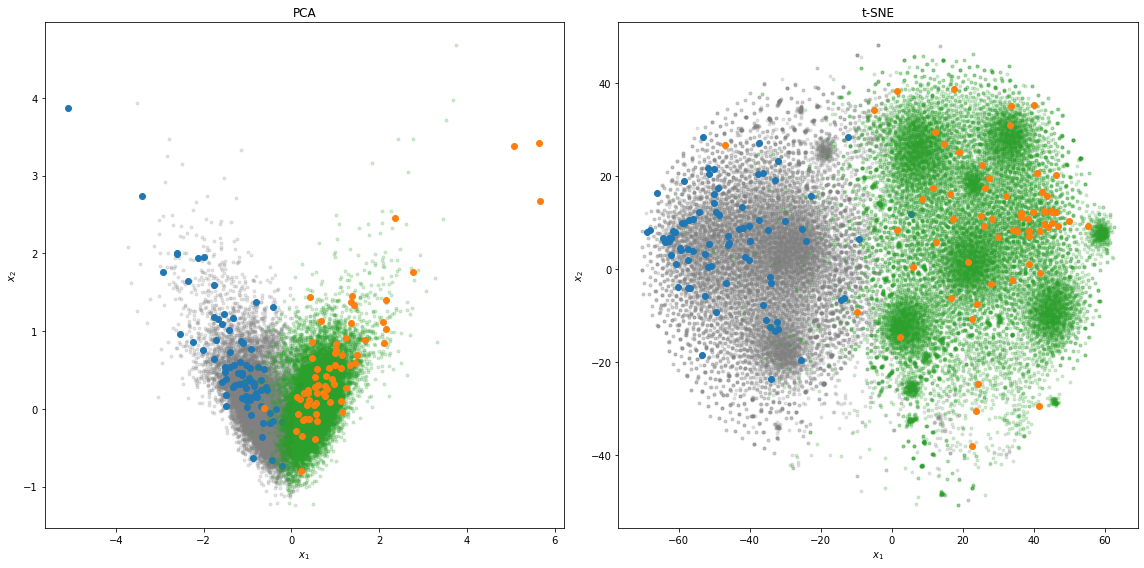

In [ ]:
#Graficamos PSA y TSNE
color = 'C0' 
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols, 8), ncols=2)
ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('PCA')
x, y = pca[comunid_2][:,0],pca[comunid_2][:,1]
ax.scatter(x,y, c='gray', marker='.', alpha=0.2)
x, y = pca[etiquetas_0][:,0],pca[etiquetas_0][:,1]
ax.scatter(x,y, c='C0')
x, y = pca[comunid_1][:,0],pca[comunid_1][:,1]
ax.scatter(x,y, c='C2', marker='.', alpha=0.2)
x, y = pca[etiquetas_1][:,0],pca[etiquetas_1][:,1]
ax.scatter(x,y, c='C1')

ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
x, y = tsne[comunid_2][:,0],tsne[comunid_2][:,1]
ax.scatter(x,y, c='gray', marker='.', alpha=0.2)
x, y = tsne[etiquetas_0][:,0],tsne[etiquetas_0][:,1]
ax.scatter(x,y,c='C0')
x, y = tsne[comunid_1][:,0],tsne[comunid_1][:,1]
ax.scatter(x,y, c='C2', marker='.', alpha=0.2)
x, y = tsne[etiquetas_1][:,0],tsne[etiquetas_1][:,1]
ax.scatter(x,y,c='C1')

plt.tight_layout()
plt.show()

In [ ]:
#Como se puede observar en los gráficos, existen dos grandes grupos de usuarios en Tw respecto a los archivos utilizados. 
#Por otro lado, se logra separar en clases para representar apoyo entre grupos de usuarios.